In [2]:
import os
import pickle
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset

In [4]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem, PandasTools


In [6]:
base_url = "https://raw.githubusercontent.com/pandegroup/reaction_prediction_seq2seq/master/processed_data/"
sets = ["train", "test", "valid"]
types = ["sources", "targets"]
files = ["vocab"]
for s in sets:
    for t in types:
        files.append("%s_%s"%(s, t))
print(files)

['vocab', 'train_sources', 'train_targets', 'test_sources', 'test_targets', 'valid_sources', 'valid_targets']


In [7]:
target_dir = "./pande_data"
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
for filename in files:
    target_file = '%s/%s'%(target_dir, filename)
    if not os.path.exists(target_file):
        urllib.request.urlretrieve(base_url + filename, target_file)

In [8]:
def parse_line_source(line):
    tokens = line.split(" ")
    klass = tokens[0]
    smiles = "".join(tokens[1:])
    return klass, smiles
def parse_line_target(line):
    tokens = line.split(" ")
    smiles = "".join(tokens)
    return smiles

In [9]:
dataframes = []
for s in sets:
    target_file = f"{target_dir}/{s}_targets"
    source_file = f"{target_dir}/{s}_sources"   
    with open(target_file, "r") as f:
        target_lines = f.readlines()
    with open(source_file, "r") as f:
        source_lines = f.readlines()
    parsed_sources = [parse_line_source(line.strip()) for line in source_lines]
    parsed_targets = [parse_line_target(line.strip()) for line in target_lines]
    data_dict = {"reactants":parsed_targets,
                "reaction_class": [t[0] for t in parsed_sources],
                "products": [t[1] for t in parsed_sources],
                "set": [s]*len(parsed_sources)}
    dataframe = pd.DataFrame(data_dict)
    dataframes.append(dataframe)
                 
data = pd.concat(dataframes, ignore_index=True)

In [10]:
data.head()

,reactants,reaction_class,products,set
0,CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(...,<RX_1>,O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)...,train
1,COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1,<RX_6>,Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1,train
2,CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.FC(F)(F)c...,<RX_9>,CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C,train
3,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1,<RX_6>,CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O,train
4,Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1,<RX_1>,Fc1cc2c(NC3CCCCCC3)ncnc2cn1,train


In [11]:
data.set.value_counts()

train    40029
test      5004
valid     5004
Name: set, dtype: int64

In [12]:
	
data.reaction_class.value_counts()

<RX_1>     15122
<RX_2>     11913
<RX_6>      8353
<RX_3>      5639
<RX_7>      4585
<RX_9>      1834
<RX_4>       900
<RX_8>       814
<RX_5>       650
<RX_10>      227
Name: reaction_class, dtype: int64

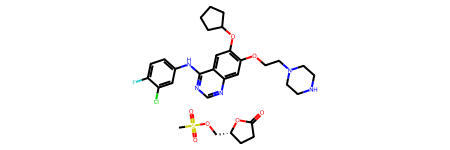

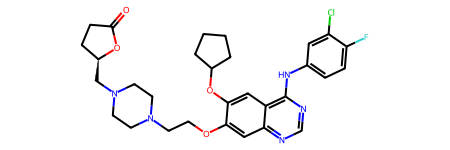

In [13]:
display(Chem.MolFromSmiles(data.reactants[0]))
display(Chem.MolFromSmiles(data.products[0]))

In [14]:
data["reactant_ROMol"] = data.reactants.apply(Chem.MolFromSmiles)
sum(data.reactant_ROMol.isna())

0

In [15]:
data["products_ROMol"] = data.products.apply(Chem.MolFromSmiles)
sum(data.products_ROMol.isna())

0

In [16]:
from molvecgen.vectorizers import SmilesVectorizer

In [17]:
import numpy as np
class SmilesIndexer(SmilesVectorizer):
     
    def tokenize(self, mols, augment=None, canonical=None):
        tokenized = []
         
        #Possible override object settings
        if augment is None:
            augment = self.augment
        if canonical is None:    
            canonical = self.canonical
        for i,mol in enumerate(mols):
             
            #Fast convert from RDKit binary
            if self.binary: mol = Chem.Mol(mol)
             
            if augment:
                mol = self.randomize_mol(mol)
            smiles = Chem.MolToSmiles(mol, canonical=canonical, isomericSmiles=self.isomericSmiles)
             
            smiles = "%s%s%s"%(self.startchar, smiles, self.endchar)
             
            tokens = torch.tensor([self._char_to_int[char] for char in smiles], dtype=torch.long)
             
            tokenized.append(tokens)
                 
        return tokenized
       
    def reverse_tokenize(self, vect, strip=True):
        smiles = []
        for v in vect:
            smile = "".join(self._int_to_char[i.item()] for i in v)
            if strip:
                smile = smile.strip(self.startchar + self.endchar)
            smiles.append(smile)
        return np.array(smiles)

In [18]:
tokenizer = SmilesIndexer()
tokenizer.fit(np.concatenate([data.reactant_ROMol.values, data.products_ROMol.values]))
tokenizer.charset = " %0" + tokenizer.charset

In [19]:
print("Dimensions:\t%s"%(str(tokenizer.dims)))
print("Charset:\t%s"%tokenizer.charset)

Dimensions:	(207, 54)
Charset:	 %0nH.O2e(b+PF4Zp=u/-C7t98Ss#]5IBN[o1\@L3)MigrcKd6l^$?


In [20]:
product_tokens = tokenizer.tokenize(data.products_ROMol[0:20])
print([len(v) for v in product_tokens])

[76, 48, 48, 42, 31, 54, 80, 68, 26, 81, 36, 73, 95, 69, 46, 45, 69, 34, 50, 43]


In [21]:
from torch.nn.utils.rnn import pad_sequence

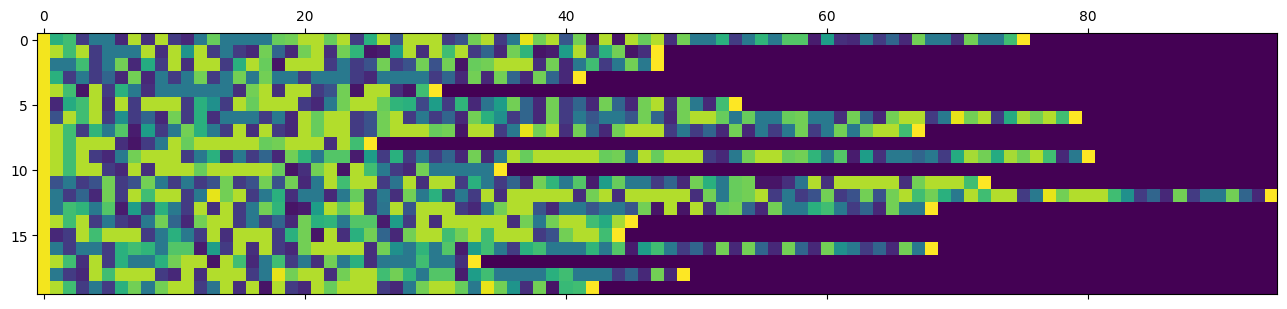

In [22]:
product_padded = pad_sequence(product_tokens)
plt.matshow(product_padded.numpy().T)

In [23]:
X_train = data.reactant_ROMol[data.set == "train"]
y_train = data.products_ROMol[data.set == "train"]
X_val = data.reactant_ROMol[data.set == "valid"]
y_val = data.products_ROMol[data.set == "valid"]

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
class MolDataset(Dataset):
    def __init__(self, reactants, products, tokenizer, augment):
        self.reactants = reactants
        self.products = products
        self.tokenizer = tokenizer
        self.augment = augment
    def __len__(self):
        return len(self.reactants)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        reactants = self.reactants.iloc[idx]
        products = self.products.iloc[idx]
        reactants_tokens = self.tokenizer.tokenize([reactants], augment=self.augment)[0]
        products_tokens = self.tokenizer.tokenize([products], augment=self.augment)[0]
         
        return reactants_tokens, products_tokens

In [26]:
train_dataset = MolDataset(X_train, y_train, tokenizer, augment=False)
val_dataset = MolDataset(X_val, y_val, tokenizer, augment=False)

In [27]:
reactant_tokens, product_tokens = val_dataset[0]
reactant_tokens

tensor([51, 21, 21, 21, 21, 21, 21, 21, 33, 21,  9, 17,  6, 41, 33,  9, 21, 41,
        46, 36, 46, 46, 46, 46,  9, 20, 46,  7, 46, 46, 46,  9, 21, 21, 21,  9,
        17,  6, 41,  6, 21, 41, 46, 46,  7,  6, 41, 46, 36,  5, 21, 50, 21, 21,
        21, 31, 52])

In [28]:
batch_size=120
def collate_fn(r_and_p_list):
    r, p = zip(*r_and_p_list)
    return pad_sequence(r), pad_sequence(p)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          num_workers=2,
                                          drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=500,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          num_workers=2,
                                          drop_last=True)

In [29]:
for reactants, products in train_loader:
    break
reactants.shape